zinv = -10.0
zinv = -319.8803450796056
zinv = -320.59424842279196
opening run1
opening run2
opening run3


/tmp/ipykernel_32627/8508151.py:220: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.plot(scm[i].t_np1[:, 0], out[i].z_r/mld, styles[i], color = colors[i],
/tmp/ipykernel_32627/8508151.py:220: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(scm[i].t_np1[:, 0], out[i].z_r/mld, styles[i], color = colors[i],
/tmp/ipykernel_32627/8508151.py:220: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  ax.plot(scm[i].t_np1[:, 0], out[i].z_r/mld, styles[i], color = colors[i],
/tmp/ipykernel_32627/8508151.py:238: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take preceden

figure saved at../figures/W005_C500_NO_COR72h_profile_LES_vs_EDMF.png


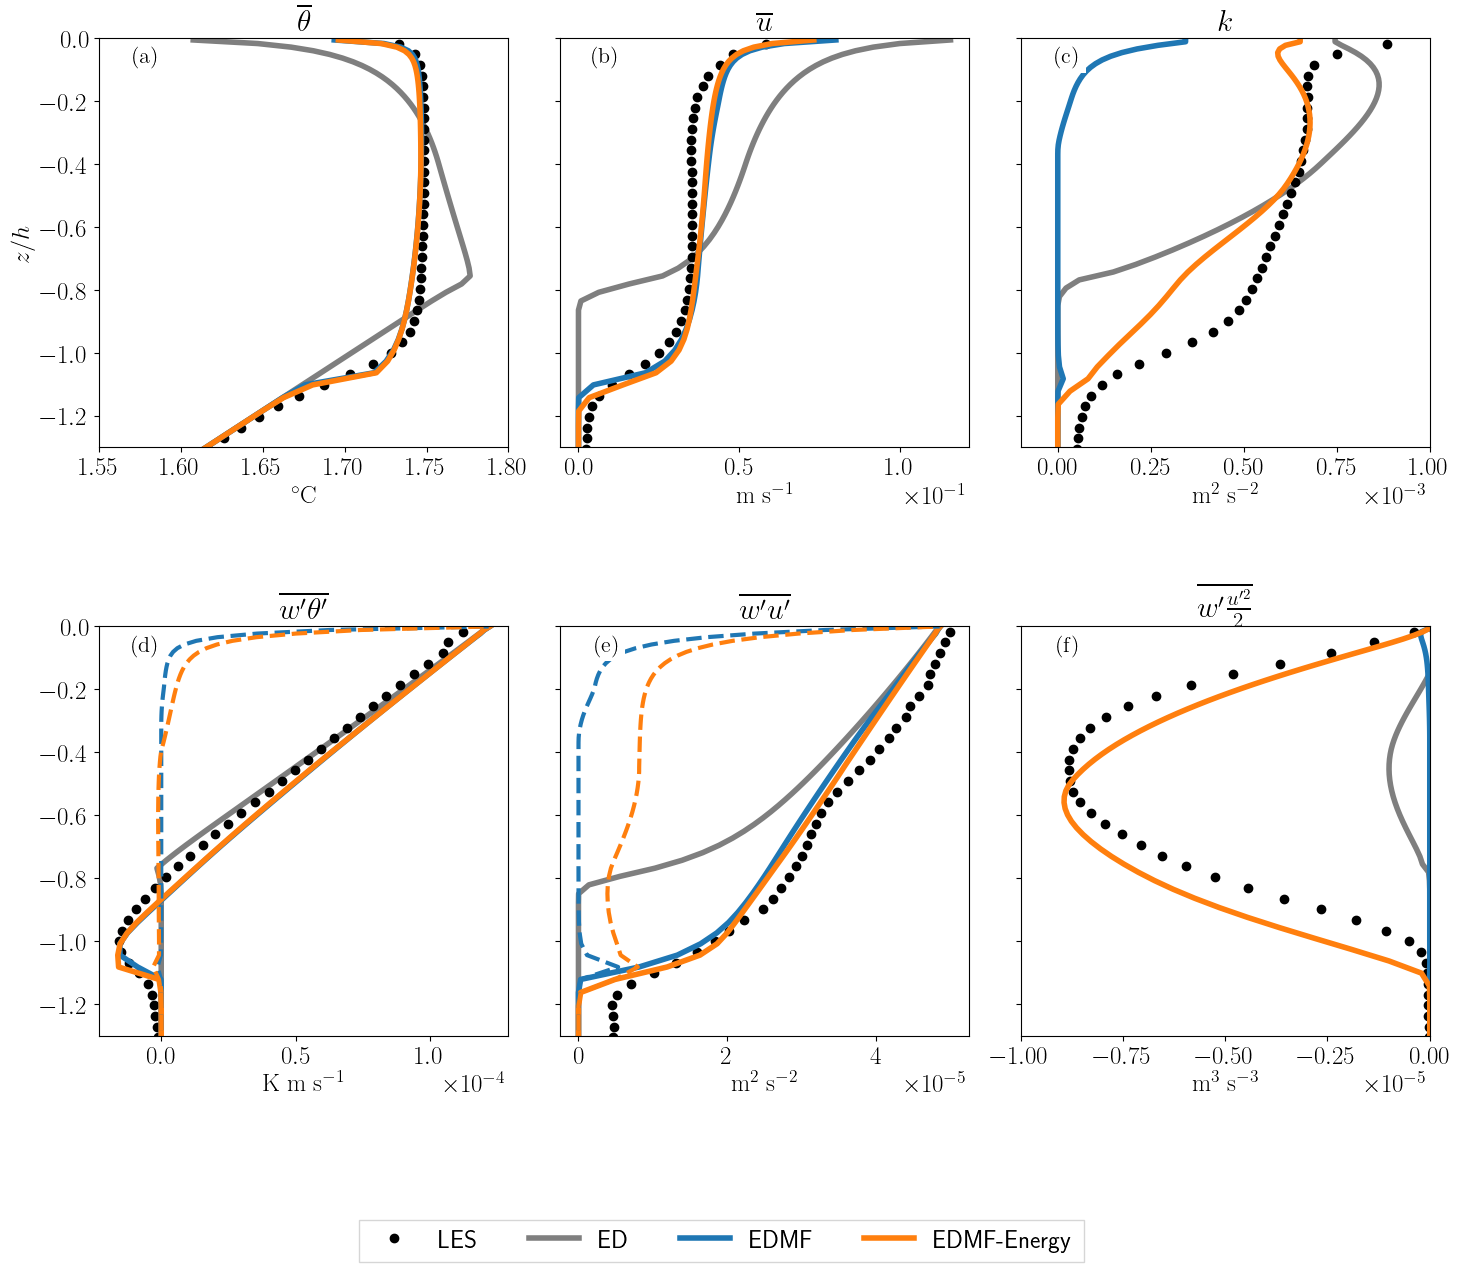

In [1]:


#!/usr/bin/env python
# coding: utf-8

import sys  # to put the SCM into the PYTHONPATH

sys.path.append('../library/F2PY')


###########################################
# Imports
###########################################
from sys import exit
import time as TIME
import xarray as xr
from scipy.interpolate import interp1d
import scipy.signal
from scm_class import SCM
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np


###################################################




plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'figure.facecolor': 'white'})
plt.rcParams.update({'savefig.facecolor': 'white'})
###########################################
# colors
blue, orange, magenta, grey, green = '#0db4c3', '#eea021', '#ff0364', '#606172', '#3fb532'

# ===========================================================================
case = 'W005_C500_NO_COR'


saving_path = '../figures/'
saving_name = case+'72h_profile_LES_vs_EDMF.png'


# loading LES output once before using the function

file = 'GN_01.1.OC_01.000_copy.nc'


path = '../data/'+case+'/'
les = xr.open_dataset(path+file)
LG_MEAN = xr.open_dataset(
    path+file, group='/LES_budgets/Mean/Cartesian/Not_time_averaged/Not_normalized/cart')
TH_les = (LG_MEAN.MEAN_TH - 273.15).data
U_les = (LG_MEAN.MEAN_U).data
V_les = (LG_MEAN.MEAN_V).data

LG_RES = xr.open_dataset(
    path+file, group='/LES_budgets/Resolved/Cartesian/Not_time_averaged/Not_normalized/cart')
LG_SBG = xr.open_dataset(
    path+file, group='/LES_budgets/Subgrid/Cartesian/Not_time_averaged/Not_normalized/cart')
WTH = (LG_RES.RES_WTH + LG_SBG.SBG_WTHL).data
WU = (LG_RES.RES_WU + LG_SBG.SBG_WU).data
WV = (LG_RES.RES_WV + LG_SBG.SBG_WV).data
corr_tke_les = 0. #-2e-04+1.0e-08
TKE = (LG_RES.RES_KE + LG_SBG.SBG_TKE).data + corr_tke_les
WTKE = (LG_RES.RES_WKE + LG_SBG.SBG_WTKE).data

time_les = les.time_les

# numpy array of integer hours, starting at inital time + 1h
time = ((time_les - time_les[0]) / np.timedelta64(1, 'h')).data.astype(int) + 1

# remap level_les on negative depth values
z_r_les = (les.level_les - (les.level_les[0] + les.level_les[-1])).data
# ===========================================================================

# Define the common parameters:
common_params = {
    'nz': 100,
    'dt': 50.,
    'h0': 2000.,
    'thetas': 6.5,
    'hc': 400,
    'nbhours': 72,
    'outfreq': 1,
    'output_filename': "scm_output.nc",
    'T0': 2.,
    'N0': 1.9620001275490499e-6,
    'Tcoef': 0.2048,
    'SaltCst': 35.,
    'lat0': 0.,
    'sustr': 0.,
    'svstr': 0.,
    'stflx': -500.,
    'srflx': 0.,
    'ssflx': 0.,
    'eddy_diff': True,
    'evd': False,
    'mass_flux_tra': True,
    'mass_flux_dyn': True,
    'mass_flux_tke': True,
    'mass_flux_tke_trplCorr': True,
    'mass_flux_small_ap': False,
    'lin_eos': True,
    'extrap_ak_surf': True,
    'tke_sfc_dirichlet': False,
    'eddy_diff_tke_const': 'NEMO',
    'entr_scheme': 'R10',
    'Cent': 0.99,
    'Cdet': 1.99,       # 'Cdet': 2.5,
    'wp_a': 1.,
    'wp_b': 1.25,      # 'wp_b': 1.
    'wp_bp': 0.003,     #      0.002,
    'up_c': 0.5,
    'vp_c': 0.5,
    'bc_ap': 0.2,    #0.3,
    'delta_bkg': 0.005,   # 0.006,
    'output_filename': 'run'
}





if case == 'W05_C500':
    common_params['sustr'] = 0.5/1027

if case == 'W005_C500_NO_COR':
    common_params['sustr'] = 0.05/1027

# Define parameters specific to each run (overwrite common parameters):

run_label = ['ED', 'EDMF', 'EDMF-Energy']
runs = [
    {
        'eddy_diff': True,
        'evd': False,
        'mass_flux_tra': False,
        'mass_flux_dyn': False,
        'mass_flux_tke': False,
        'mass_flux_tke_trplCorr': False,
        'output_filename': 'run1'

    },
    {
        'eddy_diff': True,
        'evd': False,
        'mass_flux_tra': True,
        'mass_flux_dyn': True,
        'mass_flux_tke': False,
        'mass_flux_tke_trplCorr': False,
        'output_filename': 'run2'
    },
        {
        'eddy_diff': True,
        'evd': False,
        'mass_flux_tra': True,
        'mass_flux_dyn': True,
        'mass_flux_tke': True,
        'mass_flux_tke_trplCorr': True,
        'output_filename': 'run3'
    }
        ]




scm = [0]*len(runs)

# Run the SCM
for i, run_params in enumerate(runs):
    params = common_params.copy()  # Create a copy of common_params
    params.update(run_params)  # Update with run_params
    scm[i] = SCM(**params)
    scm[i].run_direct()
    print("zinv =", scm[i].zinv)

# LOAD outputs

out = [0]*len(runs)

for i, run_params in enumerate(runs):
    print('opening '+run_params['output_filename'])
    out[i] = xr.open_dataset(run_params['output_filename'])

instant = 71


mld = (-z_r_les[(-WTH[instant]).argmax()]).data


################################# PLOTTING
styles = ['k-', 'b-', 'r-']
#colors = ['k',blue,orange]
colors = ['k','tab:blue','tab:orange']
alpha = [0.5,1,1]
linewidth = [4]*(len(run_label))

style_les = 'ko'
alpha_les = 1
linewidth_les = 4



#============================================ WC ===============================================
if case == 'W005_C500_NO_COR':
    fig, axes = plt.subplots(nrows=2, ncols=3, sharex=False,
                         sharey=True, figsize=(15, 12))
# ===============================================================
    ax = axes.flat[0]
    ax.set_xlabel(r'$^{\circ}{\rm C}$')
    ax.set_ylabel(r'$z / h $')
    ax.set_title(r'$\overline{\theta}$')


    ax.plot(TH_les[instant], z_r_les/mld, style_les,
            alpha=alpha_les, linewidth=linewidth_les,  label='LES')

    for i, label in enumerate(run_label):
        ax.plot(scm[i].t_np1[:, 0], out[i].z_r/mld, styles[i], color = colors[i],
                alpha=alpha[i], linewidth=linewidth[i], label=label)

    ax.set_xlim((1.55, 1.8))
    ax.set_ylim((-1.3, 0))


    # ===============================================================

    ax = axes.flat[1]
    ax.set_title(r'$\overline{u}$')

    ax.set_xlabel(r'${\rm m}\;{\rm s}^{-1}$')

    ax.plot(U_les[instant], z_r_les/mld, style_les,
            alpha=alpha_les, linewidth=linewidth_les, label='LES')

    for i, label in enumerate(run_label):
        ax.plot((scm[i].u_np1), scm[i].z_r/mld, styles[i], color = colors[i],
                alpha=alpha[i], linewidth=linewidth[i], label=label)

    ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
    ax.set_ylim((-1.3, 0))


    # ===============================================================


    ax = axes.flat[3]
    ax.set_title(r'$\overline{w^\prime \theta^\prime}$')

    ax.plot(WTH[instant], z_r_les/mld, style_les,
            alpha=alpha_les, linewidth=linewidth_les, label='LES')

    for i, label in enumerate(run_label):
        if run_label == 'ED':
            ax.plot(-(scm[i].wted), out[i].z_w/mld, styles[i], color = colors[i],
                    alpha=alpha[i], linewidth=linewidth[i], label=label)
        else:
            ax.plot(-(scm[i].wted + scm[i].wtmf), out[i].z_w/mld, styles[i], color = colors[i],
                    alpha=alpha[i], linewidth=linewidth[i], label=label)
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))

    ax.plot( -out[1]['WT_ED'][-1,:], out[1].z_w/mld, color ='tab:blue'  , linestyle ='--', alpha=1.0 , linewidth=3 )
    ax.plot( -out[2]['WT_ED'][-1,:], out[2].z_w/mld, color ='tab:orange', linestyle ='--', alpha=1.0 , linewidth=3 )


    ax.set_ylim((-1.3, 0))

    ax.set_xlabel(r'${\rm K}\;{\rm m}\;{\rm s}^{-1}$')


    # ===============================================================
    # ===============================================================
    ax = axes.flat[2]
    ax.set_title(r'$k$')

    ax.plot(TKE[instant], z_r_les/mld, style_les,
            alpha=alpha_les, linewidth=linewidth_les, label='LES')

    for i, label in enumerate(run_label):
        ax.plot(scm[i].tke_np1, out[i].z_w/mld, styles[i], color = colors[i],
                alpha=alpha[i], linewidth=linewidth[i], label=label)
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))

    ax.set_xlim((-0.0001, 0.001))
    ax.set_ylim((-1.3, 0))

    ax.set_xlabel(r'${\rm m}^2\;{\rm s}^{-2}$')
    # ===============================================================


    ax = axes.flat[5]
    ax.set_title(r'$\overline{w^\prime \frac{u^{\prime 2}}{2}  }$')

    ax.plot(WTKE[instant], z_r_les/mld, style_les,
            alpha=alpha_les, linewidth=linewidth_les, label='LES')

    for i, label in enumerate(run_label):
        ax.plot((scm[i].wtke), out[i].z_r/mld, styles[i], color = colors[i],
                alpha=alpha[i], linewidth=linewidth[i], label=label)


    ax.set_xlim((- 1e-5, 0))
    ax.set_ylim((-1.3, 0))

    ax.set_xlabel(r'${\rm m}^3\;{\rm s}^{-3}$')

    # ===============================================================
    ax = axes.flat[4]

    ax.set_xlabel(r'${\rm m}^2\;{\rm s}^{-2}$')
    ax.set_title(r'$\overline{w^\prime u^\prime}$')

    ax.plot(-WU[instant], z_r_les/mld, style_les,alpha=alpha_les, linewidth=linewidth_les, label='LES')


    for i, label in enumerate(run_label):
            ax.plot((scm[i].wued + scm[i].wumf), scm[i].z_w/mld, styles[i], color = colors[i],
                    alpha=alpha[i], linewidth=linewidth[i], label=label)

    ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))

    ax.plot( scm[1].wued, scm[1].z_w/mld, color ='tab:blue'  , linestyle ='--', alpha=1.0 , linewidth=3 )
    ax.plot( scm[2].wued, scm[2].z_w/mld, color ='tab:orange', linestyle ='--', alpha=1.0 , linewidth=3 )

    ax.set_ylim((-1.3, 0))



    # ===============================================================




    # adding subplot labels
    subplot_label = [r'\rm{(a)}', r'\rm{(b)}', r'\rm{(c)}',
                    r'\rm{(d)}', r'\rm{(e)}', r'\rm{(f)}']

    for i,ax in enumerate(axes.flat):
        ax.set_box_aspect(1)
        ax.text(0.15, 0.98, subplot_label[i], transform=ax.transAxes,
                fontsize=16, bbox=dict(facecolor='1.', edgecolor='none', pad=3.0), fontweight='bold', va='top', ha='right')




    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(
        0.5, -0.05), fancybox=False, shadow=False, ncol=4)

    fig.tight_layout()



###########################################################################################
#============================================ FC ==========================================
###########################################################################################

if case == 'FC500':
    fig, axes = plt.subplots(nrows=1, ncols=4, sharex=False,
                         sharey=True, figsize=(15, 5))

    # ===============================================================
    ax = axes.flat[0]
    ax.set_xlabel(r'$ C$')
    ax.set_ylabel(r'$z / h $')
    ax.set_title(r'$\overline{\theta}$')


    ax.plot(TH_les[instant], z_r_les/mld, style_les,
            alpha=alpha_les, linewidth=linewidth_les,  label='LES')

    for i, label in enumerate(run_label):
        ax.plot(scm[i].t_np1[:, 0], out[i].z_r/mld, styles[i], color = colors[i],
                alpha=alpha[i], linewidth=linewidth[i], label=label)

    ax.set_xlim((1.65, 1.78))
    ax.set_ylim((-1.3, 0))

    # ===============================================================


    ax = axes.flat[1]
    ax.set_title(r'$\overline{w^\prime \theta^\prime}$')

    ax.plot(WTH[instant], z_r_les/mld, style_les,
            alpha=alpha_les, linewidth=linewidth_les, label='LES')

    for i, label in enumerate(run_label):
        if run_label == 'ED':
            ax.plot(-(scm[i].wted), out[i].z_w/mld, styles[i], color = colors[i],
                    alpha=alpha[i], linewidth=linewidth[i], label=label)
        else:
            ax.plot(-(scm[i].wted + scm[i].wtmf), out[i].z_w/mld, styles[i], color = colors[i],
                    alpha=alpha[i], linewidth=linewidth[i], label=label)
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))

    ax.plot( -out[1]['WT_ED'][-1,:], out[1].z_w/mld, color ='tab:blue'  , linestyle ='--', alpha=1.0 , linewidth=3 )
    ax.plot( -out[2]['WT_ED'][-1,:], out[2].z_w/mld, color ='tab:orange', linestyle ='--', alpha=1.0 , linewidth=3 )

    ax.set_ylim((-1.3, 0))

    ax.set_xlabel(r'$K.m.s^{-1}$')


    # ===============================================================
    # ===============================================================
    ax = axes.flat[2]
    ax.set_title(r'$k$')

    ax.plot(TKE[instant], z_r_les/mld, style_les,
            alpha=alpha_les, linewidth=linewidth_les, label='LES')

    for i, label in enumerate(run_label):
        ax.plot(scm[i].tke_np1, out[i].z_w/mld, styles[i], color = colors[i],
                alpha=alpha[i], linewidth=linewidth[i], label=label)
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))

    ax.set_xlim((-0.0001, 0.0009))
    ax.set_ylim((-1.3, 0))

    ax.set_xlabel(r'$m^2.s^{-2}$')



    # ===============================================================
    ax = axes.flat[3]
    ax.set_title(r'$\overline{w^\prime \frac{u^{\prime 2}}{2}  }$')

    ax.plot(WTKE[instant], z_r_les/mld, style_les,
            alpha=alpha_les, linewidth=linewidth_les, label='LES')

    for i, label in enumerate(run_label):
        ax.plot((scm[i].wtke), out[i].z_r/mld, styles[i], color = colors[i],
                alpha=alpha[i], linewidth=linewidth[i], label=label)


    ax.set_xlim((- 1.1e-5, 0))
    ax.set_ylim((-1.3, 0))

    ax.set_xlabel(r'$m^3.s^{-3}$')

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(
        0.5, -0.05), fancybox=False, shadow=False, ncol=4)

    for ax in axes.flat:
        ax.set_box_aspect(1)



    fig.tight_layout()

    # ===============================================================






plt.savefig(saving_path+saving_name, bbox_inches='tight', dpi=300)


print('figure saved at'+saving_path+saving_name)

plt.show()
